## Problem 1 - Transient Conduction in a Plane Wall

The problem we consider is that of a plane wall initially at 100$^\circ$C with its outer surfaces exposed to an ambient temperature of 0$^\circ$C.  The wall has a thickness 2*L* and may be considered to have an infinite height and a unit depth. The domain is shown schematically below:

![PlaneWall](Figures/2-PlaneWall.png)

Initially, the wall only feels the effect of the ambient air very near the surface and thus, the temperature profile inside the solid is quite steep in the vicinity of the surface.  An analytical solution for this problem involves several (at least 4) terms of a Fourier series.  After some time, however, the influence of the ambient air will have reached the center of the wall and the analytical solution can be approximated by the first term of the Fourier series (see, for example, *Fundamentals of Heat and Mass Transfer* by Incropera et al.). To study the order of accuracy of the fully implicit first and second order time discretization schemes, we will consider the cooling process during a period past the initial transient where the one-term Fourier solution is valid.

The parameters for the problem are:

$$ Bi = \frac{h L}{k}= 1.0 $$

$$ T_i = 100^\circ C $$

$$ T_{\infty}= 0^\circ C $$

The one-term Fourier solution for this problem is:

$$
\frac{T-T_{\infty}}{T_i-T_{\infty}}=C_1 \exp\left(-\zeta^2\frac{\alpha t}{L^2}\right)\cos\left(\zeta \frac{x}{L}\right)
$$

where:

$$ T = T(x,t) $$

$$ \alpha = \frac{k}{\rho c_p} $$

$$ C_1 = 1.1191 $$

$$ \zeta = 0.8603 $$

The solution to this problem at the two different dimensionless time levels of interest is:

$$ \text{at } \frac{\alpha t_1}{L^2}= 0.4535,~~~ T(0,t_1)= 80^\circ C $$

$$ \text{at } \frac{\alpha t_2}{L^2}= 3.2632,~~~ T(0,t_2)= 10^\circ C $$

To solve this problem, initialize the temperature field using the analytical solution at $\alpha t_1/L^2 = 0.4535$. This avoids the need for a very small timestep during the initial transient when solution is changing rapidly. Then, use your code to calculate the temporal variation of the temperature field over the time period described above.  Solve the problem by employing 2, 4, 8, 16, and 32 time steps using both the first and second order implicit schemes.

At the end of each run, calculate the absolute average error, $\overline{e}$, using the formula:

$$
\overline{e}= \frac{1}{N_{CV}} \sum_{i=1}^{N_{CV}} |e(i)|
$$

where

$$ e(i) = T_{exact}(i) - T(i) $$ 

Then, for each scheme, plot your results of $\overline{e}$ vs. $\Delta t$ (on a log-log scale) and find the value of $p$ in the expression:

$$
\overline{e}= c (\Delta t)^p
$$

where $p$ represents the order accuracy of the transient scheme. Also show a separate plot of T(0,$t_2$) verses the number of timesteps used for each scheme employed.

Repeat this problem on at least three different grids to demonstrate grid independence of the solution.

**Bonus**: Solve the same problem using the Crank-Nicolson scheme and compare the results.



# SOLUTION

In [183]:
class RobinBc:
    """Class defining a Robinn boundary condition"""
   
    def __init__(self, phi, grid, h, k, To, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._To = To
        self._loc = loc
       
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
   
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
     
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._To))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._To))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
            

In [184]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        trans = (self._rho*self._cp*self._grid.vol)*((self._T[1:-1] - self._Told[1:-1])/self._dt)
        
        # Calculate the linearization coefficient
        
        coeffPt = (self._rho*self._cp*self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        
        coeffs.accumulate_aP(coeffPt)
        coeffs.accumulate_rP(trans)

        return coeffs

In [185]:
class SecondOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, Told2, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Told2 = Told2
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        trans = (self._rho*self._cp*self._grid.vol)*(((3*self._T[1:-1]/2) - (2*self._Told[1:-1]) + (self._Told2 [1:-1]/2))/self._dt)
        
        # Calculate the linearization coefficient
        
        coeffPt = (3*self._rho*self._cp*self._grid.vol)/(2*self._dt)
        
        # Add to coefficient arrays
        
        coeffs.accumulate_aP(coeffPt)
        coeffs.accumulate_rP(trans)

        return coeffs

## Grid Independence Test

This grid independence test is being done on the solution of the problem using the first order implicit method for the transient term

### Number of control values : 10

In [186]:
import math
import numpy as np
from numpy.linalg import norm
import math

from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel
from Classes.LinearSolver import solve


# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
print(T_solns[-1])

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 0.059119562198017665; Avg. Resid. = 0.05213114913902881
Iteration = 1; Max. Resid. = 1.1587952819525071e-15; Avg. Resid. = 5.467848396278896e-16
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 0.055509653742855394; Avg. Resid. = 0.048956586164236426
Iteration = 1; Max. Resid. = 1.2836953722228372e-15; Avg. Resid. = 6.203371150093063e-16
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 0.052119709866059336; Avg. Resid. = 0.045973223694712115
Iteration = 1; Max. Resid. = 7.077671781985373e-16; Avg. Resid. = 4.905797990062411e-16
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 0.048938314698558825; Avg. Resid. = 0.043171072167754225
Iteration = 1; Max. Resid. = 1.0547118733938987e-15; Avg. Resid. = 4.662936703425658e-16
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 0.045952586216623105; Avg. Resid. = 0.0405394848739567
Iteration = 1; Max. Resid. =

### For a number of control volumes = 40

In [187]:
import math
import numpy as np
from numpy.linalg import norm
import math

from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel
from Classes.LinearSolver import solve


# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
print(T_solns[-1])

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 0.014801275679843684; Avg. Resid. = 0.013043771632258843
Iteration = 1; Max. Resid. = 1.0047518372857667e-14; Avg. Resid. = 2.9125573480781595e-15
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 0.013898297239899193; Avg. Resid. = 0.01224769924324993
Iteration = 1; Max. Resid. = 5.504277589274409e-15; Avg. Resid. = 1.7950918529408e-15
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 0.013050426651665248; Avg. Resid. = 0.01150030738271458
Iteration = 1; Max. Resid. = 9.041378756791119e-15; Avg. Resid. = 2.8272956892338997e-15
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 0.01225423048350649; Avg. Resid. = 0.010798544541494448
Iteration = 1; Max. Resid. = 5.3681017964102296e-15; Avg. Resid. = 1.3664850501138304e-15
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 0.011506559432280029; Avg. Resid. = 0.010139612064269736
Iteration = 1; Max. Resid. =

### For a number of control volumes = 20

In [218]:
import math
import numpy as np
from numpy.linalg import norm
import math

from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel
from Classes.LinearSolver import solve


# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

#T2 = ((Ti-To)*(C1*np.exp((-z**2)*(time))*(np.cos(z*grid.xP/lx)) + Ti)


# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_exp32 = T_solns[-1]
dt32 = dt
print(T_solns[-1])

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 4.85722573273506e-15; Avg. Resid. = 1.4712189799759301e-15
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 0.027788248003949433; Avg. Resid. = 0.024491971826897246
Iteration = 1; Max. Resid. = 3.875372245332187e-15; Avg. Resid. = 1.1801323807070218e-15
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 0.026092657654584173; Avg. Resid. = 0.02299781279815599
Iteration = 1; Max. Resid. = 3.3133218391157016e-15; Avg. Resid. = 1.2486539580081057e-15
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 0.024500598868957016; Avg. Resid. = 0.021594778000266296
Iteration = 1; Max. Resid. = 1.3079815008865125e-15; Avg. Resid. = 7.189561446185877e-16
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 0.023005749532491394; Avg. Resid. = 0.02027732767565475
Iteration = 1; Max. Resid.

### Analysis

##### For a number of control values of 40

[10.66804431 10.66804431 10.66310951 10.65324219 10.63844691 10.61873053
 10.59410216 10.56457319 10.53015729 10.49087036 10.4467306  10.3977584
 10.34397644 10.28540958 10.22208492 10.15403175 10.08128154 10.00386796
  9.92182682  9.83519605  9.74401575  9.64832807  9.5481773   9.44360975
  9.33467379  9.22141982  9.10390023  8.98216938  8.85628357  8.72630104
  8.59228192  8.4542882   8.31238371  8.1666341   8.01710679  7.86387094
  7.70699743  7.54655884  7.38262938  7.21528488  7.04460275  6.95763235]


#### For a number of control values of 30

[10.66861809 10.66861809 10.6598451  10.64230632 10.61601618 10.58099631
 10.53727549 10.48488967 10.42388195 10.35430248 10.27620848 10.18966418
 10.09474072  9.99151619  9.88007545  9.76051014  9.63291859  9.49740573
  9.35408297  9.20306819  9.04448555  8.87846548  8.70514448  8.52466508
  8.3371757   8.14283052  7.94178933  7.73421747  7.52028563  7.30016972
  7.07405075  6.9580827 ]

#### For a number of control values of 20 this is the profile temperature

[10.67025731 10.67025731 10.65051796 10.61107578 10.55200374 10.4734111
 10.37544328 10.25828149 10.12214248  9.96727811  9.79397486  9.60255333
  9.39336764  9.16680478  8.92328386  8.66325539  8.38720041  8.09562961
  7.78908236  7.46812577  7.13335359  6.95936936]
  
#### For a number of control values of 10:

[10.67910454 10.67910454 10.60014488 10.44280937 10.20826132  9.89823496
  9.51502256  9.06145754  8.54089349  7.95717938  7.31463111  6.96631534]
  
#### For a number of control values of 5:

[10.71441655 10.71441655 10.39854528  9.77611492  8.86547532  7.69347301
  6.99406637]
  
#### From the previous results, without doing the GCI test on this problem, is possible to notice that after the number of control values of 20 the variance of the results is smaller making the grid independent of the results.
#### In for this problem, a number of control volumes of 20 will be used to be compared with the other methods.

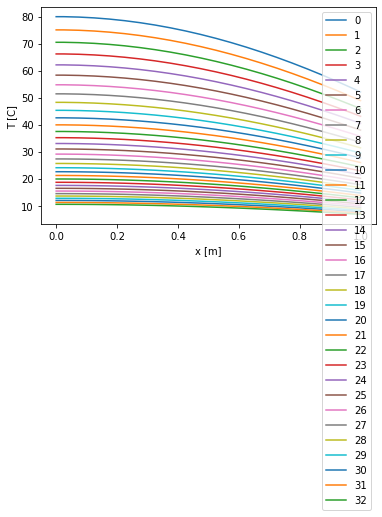

In [219]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x [m]")
plt.ylabel("T [C] ")
plt.legend()
plt.show()

### Analytical solution for the final time

In [220]:
#Definition of the variables
t2 = 3.2632

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T_final = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*t2))*np.cos((z*grid.xP[i])/lx))) + To

print (T_final)



[9.9996306  9.99731791 9.97882282 9.94186686 9.8865184  9.81287983
 9.72108738 9.61131088 9.4837534  9.33865093 9.17627191 8.99691674
 8.80091723 8.58863599 8.36046572 8.11682855 7.8581752  7.5849842
 7.29776093 6.99703677 6.68336806 6.52185993]


### Calculation of the error

In [221]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp32[1:-1]
print(err)
sum_err = np.sum(err)

err_bar32 = np.abs(sum_err)/grid.ncv

print (err_bar32)

[-0.6729394  -0.67169514 -0.66920892 -0.66548534 -0.66053127 -0.65435589
 -0.64697061 -0.63838908 -0.62862718 -0.61770295 -0.60563659 -0.59245041
 -0.57816879 -0.56281814 -0.54642685 -0.52902521 -0.51064541 -0.49132143
 -0.471089   -0.44998553]
0.5931736578195057


## Number of time step  = 2

In [222]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_exp2 = T_solns[-1]
print(T_solns[-1])
dt2 = dt

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.454633718507182e-15; Avg. Resid. = 9.070001694144736e-16
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 0.014509565669382595; Avg. Resid. = 0.012788745199506669
Iteration = 1; Max. Resid. = 1.1796119636642288e-15; Avg. Resid. = 5.05541788986541e-16
[19.22771853 19.22771853 19.19214835 19.12107379 19.01462633 18.87300291
 18.69646552 18.48534075 18.24001916 17.9609546  17.64866333 17.30372306
 16.92677193 16.51850728 16.07968437 15.61111502 15.11366605 14.58825772
 14.035862   13.45750081 12.85424407 12.54072592]


### Calculation of the error for a time step of 2

In [223]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp2[1:-1]
print(err)
sum_err = np.sum(err)

err_bar2 = np.abs(sum_err)/grid.ncv

print (err_bar2)

[-9.23040062 -9.21332553 -9.17920693 -9.12810794 -9.06012308 -8.97537814
 -8.87402987 -8.75626576 -8.62230367 -8.47239142 -8.30680632 -8.1258547
 -7.92987129 -7.71921865 -7.49428647 -7.25549085 -7.00327352 -6.73810107
 -6.46046404 -6.17087601]
8.135788793453845


### Number of time step of 4

In [224]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_exp4 = T_solns[-1]
print(T_solns[-1])
dt4 = dt

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.256875242245826e-15; Avg. Resid. = 9.663277122928803e-16
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.01947202567186679; Avg. Resid. = 0.017162606277107164
Iteration = 1; Max. Resid. = 1.9463597400459776e-15; Avg. Resid. = 8.875712664835333e-16
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 0.012812310420059704; Avg. Resid. = 0.011292850828928037
Iteration = 1; Max. Resid. = 1.1093556628871681e-15; Avg. Resid. = 3.93348548177741e-16
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 0.008430369352808498; Avg. Resid. = 0.007430593772413757
Iteration = 1; Max. Resid. = 9.792514021889076e-16; Avg. Resid. = 2.522938455373769e-16
[14.99264957 14.99264957 14.96491404 14.90949431 14.82649289 14.71606332
 14.57840991 14.41378729 14.22250001 14.00490194 13.76139563 13.4924315

In [225]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp4[1:-1]
print(err)
sum_err = np.sum(err)

err_bar4 = np.abs(sum_err)/grid.ncv

print (err_bar4)

[-4.99533166 -4.98609122 -4.96762745 -4.93997449 -4.90318349 -4.85732252
 -4.80247641 -4.73874661 -4.66625101 -4.58512372 -4.4955148  -4.39759002
 -4.29153052 -4.17753249 -4.0558068  -3.92657862 -3.79008701 -3.64658445
 -3.49633638 -3.33962075]
4.402965521272244


### Number of time step of 8

In [226]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_exp8 = T_solns[-1]
print(T_solns[-1])
dt8 = dt

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.168404344971009e-15; Avg. Resid. = 1.0678957718113225e-15
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.02348881205739417; Avg. Resid. = 0.02070288202562261
Iteration = 1; Max. Resid. = 2.473715676742927e-15; Avg. Resid. = 1.1016361434190713e-15
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 0.018643361268965465; Avg. Resid. = 0.0164323324860971
Iteration = 1; Max. Resid. = 2.0469737016526324e-15; Avg. Resid. = 9.3119956190435e-16
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.014797574932387649; Avg. Resid. = 0.013042687401363415
Iteration = 1; Max. Resid. = 1.052977149917922e-15; Avg. Resid. = 3.8606270957863844e-16
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 0.011745131898491933; Avg. Resid. = 0.010352252152922115
Iteration = 1; Max. 

In [227]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp8[1:-1]
print(err)
sum_err = np.sum(err)

err_bar8 = np.abs(sum_err)/grid.ncv

print (err_bar8)

[-2.60181724 -2.59700467 -2.58738843 -2.5729863  -2.55382494 -2.52993977
 -2.50137498 -2.46818341 -2.43042645 -2.38817394 -2.34150403 -2.29050305
 -2.23526534 -2.17589306 -2.11249604 -2.04519155 -1.97410407 -1.89936511
 -1.82111289 -1.73949217]
2.293302371239995


### Number of time step of 16

In [228]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    
T_exp16 = T_solns[-1]
print(T_solns[-1])
dt16 = dt
print (dt16)

Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 0.029593993706063772; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 3.0600522116230877e-15; Avg. Resid. = 1.1480399964014509e-15
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.026190218384689955; Avg. Resid. = 0.023083704849656585
Iteration = 1; Max. Resid. = 2.858824288409778e-15; Avg. Resid. = 1.0709315378942819e-15
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 0.023178044993851187; Avg. Resid. = 0.020429103033228636
Iteration = 1; Max. Resid. = 2.159730727591125e-15; Avg. Resid. = 7.647528443843754e-16
Timestep = 3; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.02051243451226128; Avg. Resid. = 0.018079752454512384
Iteration = 1; Max. Resid. = 3.138114768042044e-15; Avg. Resid. = 8.592952738251114e-16
Timestep = 4; Time = 1.3315312499999998
Iteration = 0; Max. Resid. = 0.018153446075237414; Avg. Resid. = 0.01600057069598427
Iteration = 1; Max. Resid

In [229]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp16[1:-1]
print(err)
sum_err = np.sum(err)

err_bar16 = np.abs(sum_err)/grid.ncv

print (err_bar16)

[-1.32890776 -1.32644999 -1.32153901 -1.31418389 -1.30439824 -1.29220016
 -1.2776122  -1.26066135 -1.24137895 -1.21980066 -1.19596641 -1.16992026
 -1.14171039 -1.11138896 -1.07901207 -1.04463959 -1.00833508 -0.9701657
 -0.93020203 -0.88851799]
1.1713495346385474


[1.40485    0.702425   0.3512125  0.17560625 0.087803  ]
[8.13578879 4.40296552 2.29330237 1.17134953 0.59317366]
Value of P is: 5.7103734174983005


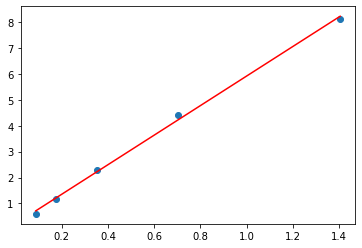

In [233]:
#To generate the plot of e bar vs deltat

from scipy import stats
import numpy as np

x = np.array([dt2, dt4, dt8, dt16, dt32])
print (x)
y = np.array([err_bar2, err_bar4, err_bar8, err_bar16, err_bar32])

print (y)

res = stats.linregress(x, y)

#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print ("Value of P is:", slope)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

## Second order implicit scheme

### Number of time step = 2

In [201]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


#Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(Told) 
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

print (T_solns[-1])
T_exp = T_solns[-1]


Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 0.02959399370606377; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.2794266474335245e-15; Avg. Resid. = 7.741203511546502e-16
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 0.02330573956211135; Avg. Resid. = 0.020541666789469448
Iteration = 1; Max. Resid. = 1.618497003086361e-15; Avg. Resid. = 5.820864623640176e-16
[21.45779565 21.45779565 21.41810013 21.33878253 21.21998957 21.061941
 20.86492922 20.62931865 20.35554516 20.04411521 19.69560489 19.31065891
 18.88998939 18.4343745  17.94465708 17.42174303 16.86659969 16.28025397
 15.66379054 15.01834976 14.34512559 13.99524447]


In [202]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp[1:-1]
print(err)
sum_err = np.sum(err)

err_bar2 = np.abs(sum_err)/grid.ncv

print (err_bar2)

[-11.46047774 -11.43927731 -11.39691566 -11.33347117 -11.24906117
 -11.14384183 -11.01800777 -10.87179176 -10.70546428 -10.51933298
 -10.31374217 -10.08907216  -9.84573852  -9.58419136  -9.30491449
  -9.00842448  -8.69526978  -8.36602961  -8.02131299  -7.66175753]
10.10140473750319


### Number of time step = 4

In [203]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


#Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(Told) 
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

print (T_solns[-1])
T_exp = T_solns[-1]

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.02959399370606377; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.4216739724636227e-15; Avg. Resid. = 1.0911410663894117e-15
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.029303448646646323; Avg. Resid. = 0.025827929555584626
Iteration = 1; Max. Resid. = 2.1892210266827306e-15; Avg. Resid. = 7.998809947729058e-16
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 0.02169036654124352; Avg. Resid. = 0.019118071575723365
Iteration = 1; Max. Resid. = 1.2160411566597418e-15; Avg. Resid. = 6.06893008070486e-16
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 0.014223913630089225; Avg. Resid. = 0.012537098707263983
Iteration = 1; Max. Resid. = 7.324869877312068e-16; Avg. Resid. = 1.8810907692623502e-16
[14.03827954 14.03827954 14.01230957 13.96041766 13.88269981 13.77929981
 13.65040891 13.49626558 13.31715495 13.11340838 12.88540277 12.63355

In [204]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp[1:-1]
print(err)
sum_err = np.sum(err)

err_bar4 = np.abs(sum_err)/grid.ncv

print (err_bar4)

[-4.04096163 -4.03348674 -4.0185508  -3.99618141 -3.96641998 -3.92932153
 -3.8849547  -3.83340155 -3.77475745 -3.70913086 -3.63664318 -3.55742849
 -3.47163332 -3.37941637 -3.28094823 -3.17641102 -3.06599813 -2.94991379
 -2.82837274 -2.70159979]
3.5617765855830266


### Number of time step = 8

In [205]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


#Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(Told) 
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

print (T_solns[-1])
T_exp = T_solns[-1]

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.029593993706063762; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 2.824129818890242e-15; Avg. Resid. = 1.206673649889467e-15
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.03363099109185132; Avg. Resid. = 0.029642003800944644
Iteration = 1; Max. Resid. = 2.6749435999562365e-15; Avg. Resid. = 9.450773497121644e-16
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 0.029811254475171148; Avg. Resid. = 0.026275781990857554
Iteration = 1; Max. Resid. = 2.8171909249863347e-15; Avg. Resid. = 1.5319343016351184e-15
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 0.02432372310638553; Avg. Resid. = 0.021439160089083083
Iteration = 1; Max. Resid. = 1.3912482277333993e-15; Avg. Resid. = 5.060188379424346e-16
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 0.019172741540370998; Avg. Resid. = 0.01689903287084614
Iteration = 1; Ma

In [206]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp[1:-1]
print(err)
sum_err = np.sum(err)

err_bar8 = np.abs(sum_err)/grid.ncv

print (err_bar8)

[-1.46839104 -1.46567524 -1.46024867 -1.45212135 -1.44130832 -1.42782958
 -1.41171006 -1.39297958 -1.37167276 -1.34782903 -1.32149248 -1.29271182
 -1.26154028 -1.22803551 -1.19225948 -1.15427836 -1.1141624  -1.07198578
 -1.02782652 -0.98176628]
1.294291227371798


### Number of time step = 16

In [207]:
# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
totalT = 3.2632 - 0.4535
dt = totalT/nTime
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


#Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(Told) 
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

print (T_solns[-1])
T_exp = T_solns[-1]

Timestep = 0; Time = 0.62910625
Iteration = 0; Max. Resid. = 0.02959399370606375; Avg. Resid. = 0.026083070032713308
Iteration = 1; Max. Resid. = 4.89538964920655e-15; Avg. Resid. = 2.02320799003175e-15
Timestep = 1; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 0.036312429278223986; Avg. Resid. = 0.032005119726379795
Iteration = 1; Max. Resid. = 3.552713678800501e-15; Avg. Resid. = 1.0347625534201654e-15
Timestep = 2; Time = 0.9803187499999999
Iteration = 0; Max. Resid. = 0.0354780206261893; Avg. Resid. = 0.03127023270904478
Iteration = 1; Max. Resid. = 2.230854390106174e-15; Avg. Resid. = 9.892260621757742e-16
Timestep = 3; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 0.03239350277232063; Avg. Resid. = 0.028551833257287523
Iteration = 1; Max. Resid. = 2.4667767828390197e-15; Avg. Resid. = 7.57900686654267e-16
Timestep = 4; Time = 1.3315312499999998
Iteration = 0; Max. Resid. = 0.028864794497943616; Avg. Resid. = 0.025441690892666236
Iteration = 1; Max. Resid. = 1.7

In [208]:
#To calculate the value of e 

err = T_final[1:-1] - T_exp[1:-1]
print(err)
sum_err = np.sum(err)

err_bar16 = np.abs(sum_err)/grid.ncv

print (err_bar16)

[-0.67444242 -0.67319538 -0.67070361 -0.6669717  -0.66200657 -0.65581739
 -0.6484156  -0.6398149  -0.63003118 -0.61908253 -0.60698921 -0.59377356
 -0.57946003 -0.56407508 -0.54764716 -0.53020664 -0.51178577 -0.49241861
 -0.47214097 -0.45099034]
0.5944984321139319


### Number of time step = 32

In [209]:
import math

# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

#Analytical temperature for initial condition

C1 = 1.1191
z = 0.8603
Ti = 100

T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*np.exp((-z**2)*time))*np.cos((z*grid.xP[i])/lx))) + To


#Define boundary conditions
west_bc = NeumannBc(T, grid, 0 , BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(Told) 
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)


# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

print (T_solns[-1])
T_exp = T_solns[-1]

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 0.02959399370606373; Avg. Resid. = 0.0260830700327133
Iteration = 1; Max. Resid. = 4.014150123410332e-15; Avg. Resid. = 1.1875916916537222e-15
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 0.037820249115702254; Avg. Resid. = 0.033333811966880685
Iteration = 1; Max. Resid. = 4.479056014972116e-15; Avg. Resid. = 1.5737411374061595e-15
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 0.038877985728728554; Avg. Resid. = 0.03426652891577232
Iteration = 1; Max. Resid. = 2.96637714392034e-15; Avg. Resid. = 1.3022569134157892e-15
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 0.03760157947136939; Avg. Resid. = 0.03314191666203678
Iteration = 1; Max. Resid. = 1.4536982728685643e-15; Avg. Resid. = 5.903263988749075e-16
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 0.035632561608742126; Avg. Resid. = 0.031406678232856935
Iteration = 1; Max. Resid. = 1.

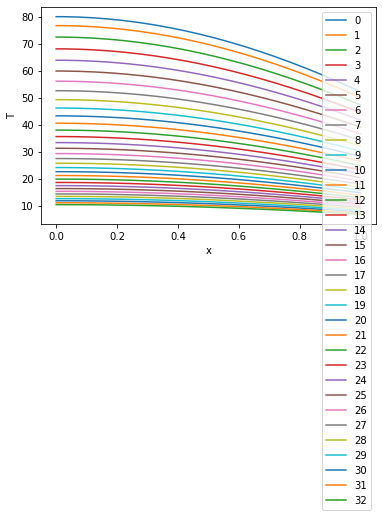

In [210]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [211]:
err = T_final[1:-1] - T_exp[1:-1]
print(err)
sum_err = np.sum(err)

err_bar32 = np.abs(sum_err)/grid.ncv

print (err_bar32)

[-0.33241613 -0.33180181 -0.33057432 -0.32873592 -0.32629001 -0.32324111
 -0.31959485 -0.31535797 -0.3105383  -0.30514475 -0.29918728 -0.29267691
 -0.28562567 -0.27804658 -0.26995365 -0.26136185 -0.25228704 -0.242746
 -0.23275635 -0.22233657]
0.29303365280595883
